# Load as LUME-model for use with EPICS data

Loads the base neural network model, the `sim_to_nn` & `pv_to_sim` transformers and the PV variable specification from their respective files to create a [LUME-model](https://github.com/slaclab/lume-model/). The resulting instance of `PyTorchModel` enforces requirements on the input and output variables and can be wrapped in a `LUMEModule`. The `LUMEModule` can be used like a `torch.nn.Module` and is tested on a small set of data.

When working with EPICS PV data, it's important to remember that the data you pull from the archive will require some post-processing before it can be used with the surrogate model below. 

For example:
* outliers may need to be removed
* unphysical values may need to be removed (e.g. XRMS and YRMS values below 0)
* values for features that lie outside the training distribution should be removed
* values for unmeasurable PVs (such as the pulse length) will need to be imputed (`Pulse_length`)
* values for features that were not varied in the training data will need to be overwritten with the PV unit equivalent of the value used during training (`FBCK:BCI0:1:CHRG_S` and `ACCL:IN20:400:L0B_ADES`)
* compound PVs (PVs created from a calculation using measured PVs) will need to be calculated (`CAMR:IN20:186:R_DIST`)

`CAMR:IN20:186:R_DIST` is calculated from `CAMR:IN20:186:XRMS` and `CAMR:IN20:186:YRMS` using the following formula:
```python
r_dist = np.sqrt(data["CAMR:IN20:186:XRMS"].values ** 2 + data["CAMR:IN20:186:YRMS"].values ** 2)
```

Further information about the specific changes that need to be applied for this model can be found in the [README](README.md) and the [PV variable specification](model/pv_variables.yml). 

In [1]:
import torch
import matplotlib.pyplot as plt

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

## Create model

In [2]:
# load sim_to_nn transformers
input_sim_to_nn = torch.load("model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load("model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load('model/input_pv_to_sim.pt')
output_pv_to_sim = torch.load('model/output_pv_to_sim.pt')

In [3]:
# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open("model/pv_variables.yml"))

In [4]:
# create LUME-model
lume_model = PyTorchModel(
    model_file="model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

In [5]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs,
)
lume_module

LUMEModule(
  (base_model): Sequential(
    (0): Linear(in_features=16, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=200, out_features=300, bias=True)
    (9): ELU(alpha=1.0)
    (10): Dropout(p=0.05, inplace=False)
    (11): Linear(in_features=300, out_features=300, bias=True)
    (12): ELU(alpha=1.0)
    (13): Dropout(p=0.05, inplace=False)
    (14): Linear(in_features=300, out_features=200, bias=True)
    (15): ELU(alpha=1.0)
    (16): Dropout(p=0.05, inplace=False)
    (17): Linear(in_features=200, out_features=100, bias=True)
    (18): ELU(alpha=1.0)
    (19): Dropout(p=0.05, inplace=False)
    (20): Linear(in_features=100, out_features=100, bias=True)
    (21): ELU(alpha=1.0)
    (22): Linear(in_f

## Test on example data

In [6]:
# load example data and calculate predictions
inputs_small = input_pv_to_sim.untransform(torch.load("info/inputs_small.pt"))
outputs_small = output_pv_to_sim.untransform(torch.load("info/outputs_small.pt"))
with torch.no_grad():
    predictions = lume_module(inputs_small)

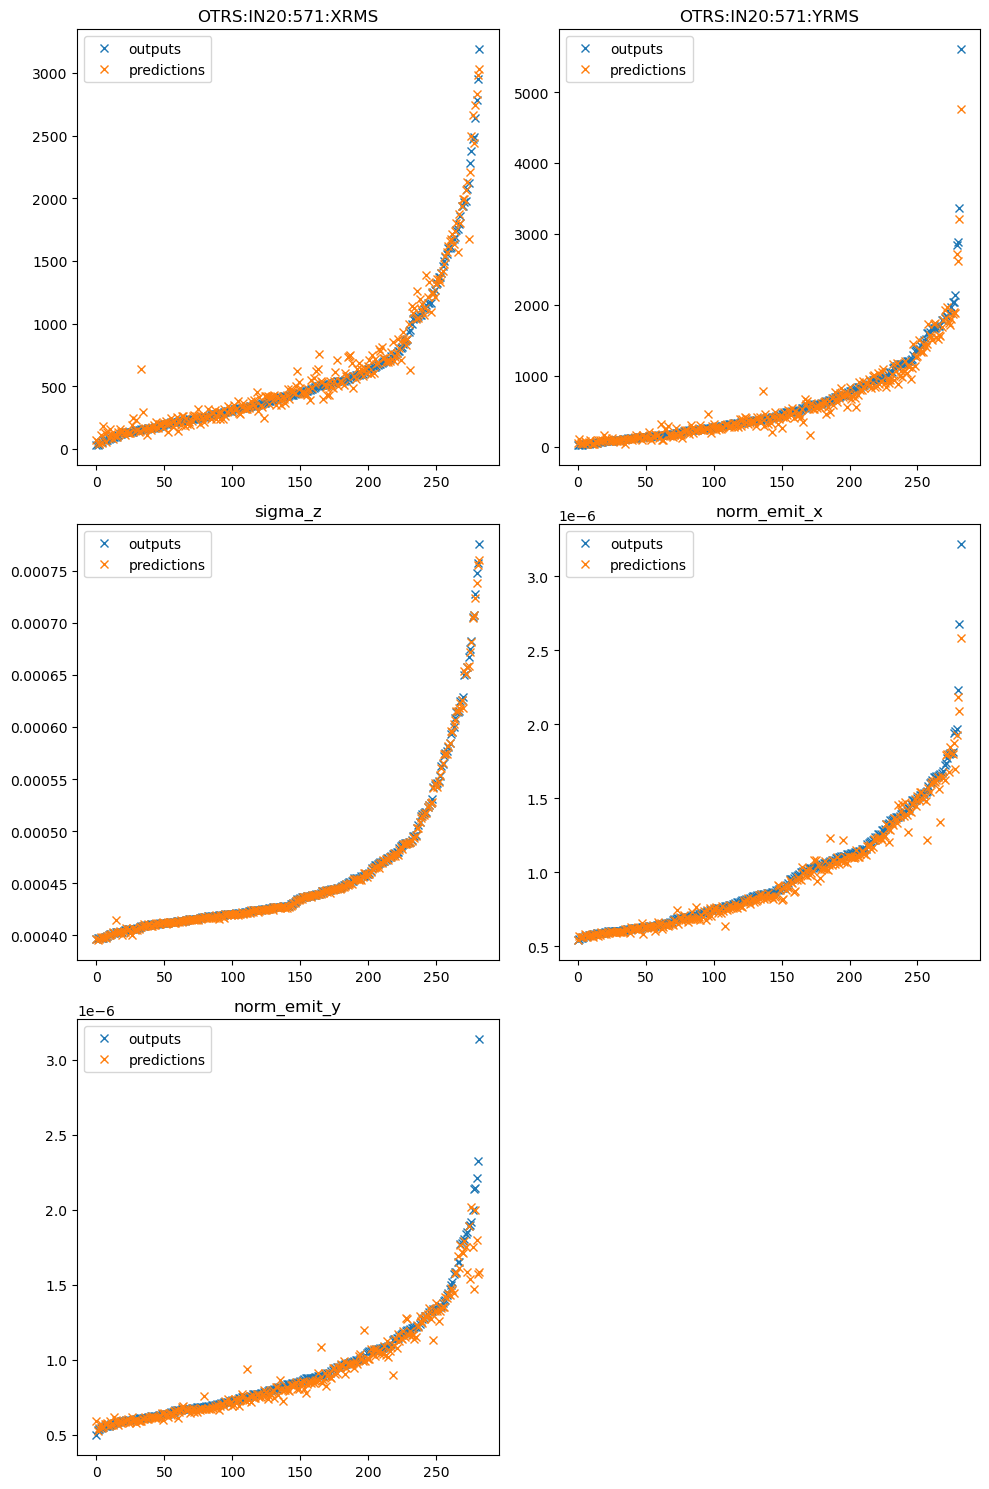

In [7]:
# plot example data and predictions
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
for i, output_name in enumerate(lume_module.output_order):
    ax_i = ax[i // ncols, i % ncols]
    if i < outputs_small.shape[1]:
        sort_idx = torch.argsort(outputs_small[:, i])
        x_axis = torch.arange(outputs_small.shape[0])
        ax_i.plot(x_axis, outputs_small[sort_idx, i], "C0x", label="outputs")
        ax_i.plot(x_axis, predictions[sort_idx, i], "C1x", label="predictions")
        ax_i.legend()
        ax_i.set_title(output_name)
ax[-1, -1].axis('off')
fig.tight_layout()

## Missing Output PVs

If we have missing outputs, for example outputs of the model that are not measured in EPICS, we can simply remove these from the `LUMEModule` by passing a truncated list to `output_order` (they still need to be listed in the PyTorchModel though).

In [8]:
# wrap in truncated LUMEModule
truncated_lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs[0:2],  # truncate list of parameters
)
truncated_lume_module.output_order

['OTRS:IN20:571:XRMS', 'OTRS:IN20:571:YRMS']

In [9]:
# calculate predictions
with torch.no_grad():
    predictions = truncated_lume_module(inputs_small)
predictions.shape

torch.Size([283, 2])

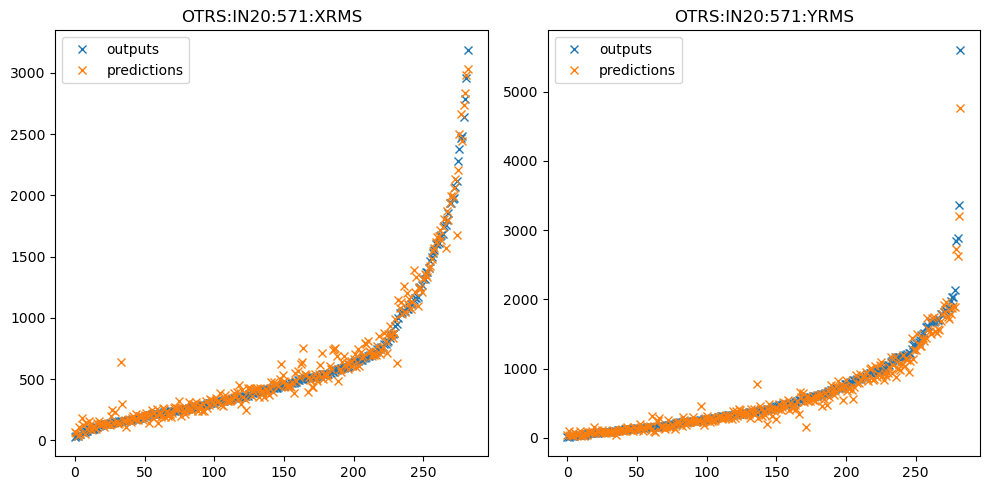

In [10]:
# plot example data and predictions
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for i, output_name in enumerate(truncated_lume_module.output_order):
    sort_idx = torch.argsort(outputs_small[:, i])
    x_axis = torch.arange(outputs_small.shape[0])
    ax[i].plot(x_axis, outputs_small[sort_idx, i], "C0x", label="outputs")
    ax[i].plot(x_axis, predictions[sort_idx, i], "C1x", label="predictions")
    ax[i].legend()
    ax[i].set_title(output_name)
fig.tight_layout()